In [33]:
# Generales
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import pandas as pd
import numpy as np

# Sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer  # Stopwords

# Tensorflow y Keras
import tensorflow as tf
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
def get_dictionary(text, sw, N):
    vectorizer = CountVectorizer(stop_words=sw, max_features=N)
    vectorizer.fit_transform(text)
    dictionary = vectorizer.vocabulary_
    dictionary = {word: i + 2 for i, word in enumerate(vectorizer.get_feature_names_out())}
    dictionary['DESC'] = 0
    dictionary['PAD'] = 1
    return dictionary

In [35]:
def text_to_sequence(text, dictionary, stop_words, T):
    palabras = re.findall(r'\b\w+\b', text.lower()) #Tokenizar
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    secuencia = [dictionary.get(palabra, dictionary['DESC']) for palabra in
    palabras]
    secuencia = secuencia[:T]
    secuencia += [dictionary['PAD']] * (T - len(secuencia))
    return np.array(secuencia)

In [36]:
# Parámetros configurables
N = 20000  # Número de palabras del diccionario
T = 100    # Longitud prefijada de la reseña
EPOCHS = 10
NEURONAS = 128

# Usamos la lista de stopwords de sklearn
stop_words = list(ENGLISH_STOP_WORDS)

path = "/kaggle/input/tripadvisor-ejercicio/tripadvisor_hotel_reviews.csv"

datos = pd.read_csv(path)

In [37]:
datos.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [38]:
# Variable objetivo
y = datos.iloc[:, -1]
num_clases = len(y.unique())
# Codificamos con "one hot" las posibles categorías finales
y = pd.get_dummies(datos['Rating'], columns=['Rating'])

# Textos de reseñas
textos = datos['Review']
X = []
diccionario = get_dictionary(textos, stop_words, N)
for texto in textos:
    X.append(text_to_sequence(texto, diccionario, stop_words, T))
# X contendrá las reseñas codificadas y rellenas con la misma longitud
X = np.array(X)

In [39]:
# Categorías finales con one hot
print(y)

           1      2      3      4      5
0      False  False  False   True  False
1      False   True  False  False  False
2      False  False   True  False  False
3      False  False  False  False   True
4      False  False  False  False   True
...      ...    ...    ...    ...    ...
20486  False  False  False  False   True
20487  False  False  False   True  False
20488  False   True  False  False  False
20489   True  False  False  False  False
20490  False   True  False  False  False

[20491 rows x 5 columns]


In [40]:
print(textos)

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms not 4* experience hotel monaco seat...
3        unique, great stay, wonderful time hotel monac...
4        great stay great stay, went seahawk game aweso...
                               ...                        
20486    best kept secret 3rd time staying charm, not 5...
20487    great location price view hotel great quick pl...
20488    ok just looks nice modern outside, desk staff ...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking, ca n't believe excellent ratin...
Name: Review, Length: 20491, dtype: object


In [41]:
first_key, first_value = next(iter(diccionario.items()))
print(first_key, first_value)

00 2


In [42]:
print(X)

[[12030  8940  6760 ...     1     1     1]
 [12381 16683  3588 ... 17457  5459  7380]
 [12030 15256     0 ...  5906 15246 13294]
 ...
 [12381  9922 10667 ...     1     1     1]
 [ 8940 17872 15358 ...  2674  8950 10495]
 [13120 17634  3086 ...     1     1     1]]


In [43]:
X.shape

(20491, 100)

In [44]:
y.shape[1]

5

In [45]:
X.shape[1]

100

In [46]:
textos = datos['Review']
X = pad_sequences(textos.apply(lambda t: text_to_sequence(t, diccionario, stop_words, T)), 
                  maxlen=T, padding='post')  # T debe ser la longitud deseada (ej: 100)
y = pd.get_dummies(datos['Rating'])

In [47]:
print(X.shape[0])
print(y.shape)

20491
(20491, 5)


In [48]:
N = 5  # Tamaño del vocabulario
D = 5  # Dimensión del embedding
embedding_layer = Embedding(input_dim=N, output_dim=D)
entrada = np.array([[4, 3, 1, 1, 3]])
embeddings = embedding_layer(entrada)
print('Representación de {}'.format(str(entrada)))
print(embeddings.numpy())

Representación de [[4 3 1 1 3]]
[[[-0.01326614 -0.00948194  0.03263896 -0.02798877  0.02600631]
  [-0.00205116 -0.01534449 -0.04363626  0.00500761  0.01299552]
  [-0.01417335 -0.02873235 -0.04978274  0.02422155 -0.04908501]
  [-0.01417335 -0.02873235 -0.04978274  0.02422155 -0.04908501]
  [-0.00205116 -0.01534449 -0.04363626  0.00500761  0.01299552]]]


In [49]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS, return_sequences=True)),
    Bidirectional(LSTM(units=NEURONAS)),
    Dense(units=num_clases, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 100, 5)              │              35 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 100, 256)            │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 532,776 (2.03 MB)

 Trainable params: 532,776 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(X, y, validation_split=0.2, epochs=EPOCHS, batch_size=128, verbose=1)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4118 - loss: 1.4090 - val_accuracy: 0.4899 - val_loss: 1.2955
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4336 - loss: 1.3680 - val_accuracy: 0.4909 - val_loss: 1.3165
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4339 - loss: 1.3606 - val_accuracy: 0.4899 - val_loss: 1.2864
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4240 - loss: 1.3688 - val_accuracy: 0.4909 - val_loss: 1.2819
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4266 - loss: 1.3617 - val_accuracy: 0.4896 - val_loss: 1.2799
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4356 - loss: 1.3478 - val_accuracy: 0.4887 - val_loss: 1.2896
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4300 - loss: 1.3539 - val_accuracy: 0.4899 - val_loss: 1.2986
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4298 - loss: 1.3524 - val_acc

In [51]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

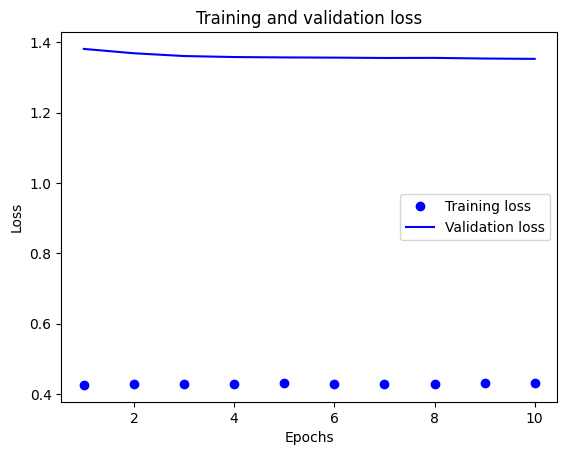

In [52]:
acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()